In [3]:


%load_ext autoreload
%autoreload 2
%load_ext line_profiler


import numpy as np
import DemandEstimation_v2 as DE
from tqdm.notebook import tqdm
from statsmodels.regression.linear_model import OLS 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



#### Setting true parameters and simulating one period market

In [2]:
# setting parameters 

f=2 # Firms
j=2# Products
k=2 # Traits (of each product) 
data = DE.endog_data()
X, prod=data.simulate_product_traits(f,j,k, which_type = "Identical")
X = X.reshape(j*f, -1)

# True Parameters 
alpha = -0.02                # Price sensitivity
beta= np.array([1,2])        # Preference for traits 
mc = np.array([60,60, 70 ,40])           # Marginal costs of producing each product
theta = np.append(alpha,beta)  

# Simulating data: 
P = np.zeros((f*j)) +1               #Initital price vector
data.sim_data(P, theta, X, mc, prod, f, j)


TypeError: sim_data() missing 1 required positional argument: 'J'

In [ ]:
# I could add shocks to production costs over time (ar(1) + noise). That would induce variation over time in prices. 
# I think when MC is perfectly known we lose one dimension of noise. Hence what is left is noise wrt. to demand. But the distribution is known and hence create the logit demand system. 

#### Simulating multiple markets

In [54]:
# setting parameters 

f=2 # Firms
j=2# Products
k=2 # Traits (of each product) 

data = DE.endog_data()
X, prod=data.simulate_product_traits(f,j,k, which_type = "Differentiated")
X = X.reshape(j*f, -1)

# True Parameters 
alpha = -2                # Price sensitivity
beta= np.array([2,2])        # Preference for traits 
theta = np.append(alpha,beta)  
cov = np.array([[1,0.5],[0.5,1]])
#cov = np.array([[1,0.0],[0.0,1]])
gamma = np.array([1,1])
T = 10
P0 = np.zeros((f*j)) +1               #Initital price vector

#mc=data.mc_sim(X, gamma,T=T, noise_type = "Triangular")

In [55]:
#P, S = data.sim_data_T(X, f, j, T, theta, gamma, cov, prod)
#S.min()
S = np.array(0) 
while S.min() == 0.0:
    P, S = data.sim_data_T(X, f, j, T, theta, gamma, cov, prod)
    print(S.min()==0.0)


TypeError: sim_data_T() missing 1 required positional argument: 'H'

#### Using OLS to solve the system: 
1) Divide by outside option and Log transform the system. 

In [ ]:
P[:,9]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [53]:
# OLS: 
# But I do not have the outside option in my data... I can construct it easily. 
S0=(1-np.sum(S,axis=0))

index=np.log(S/S0).reshape(-1,1)

# OLS with endogenous prices
P1 = P.reshape(-1,1)
XX = np.hstack((P1, X.repeat(T, axis=0)))
#XX = XX[:,0:2]
resultsp=OLS(index,XX).fit()
resultsp.params

# OLS with MC instead



NameError: name 'S' is not defined

#### Using 2-step IV: 

In [52]:
check = np.array(np.arange(j*f))
Z = []
for firm, js in prod.items():
    not_f_prods=[j for j in check if j not in js ]
    
    Z_i = X[not_f_prods,:].mean(axis=0)
    
    Z.append(Z_i)
    
Z = np.array(Z) 

ZZ = Z.repeat(T, axis=0)
Piv1 = P.reshape(-1)


results1step=OLS(P1,ZZ).fit()
results1step.params

EP = (ZZ @ results1step.params).reshape(-1,1)

# Step 2 IV: 
ZX = np.hstack((EP, X.repeat(T, axis=0)))
#XX = XX[:,0:2]
resultsIV=OLS(index,ZX).fit()
resultsIV.params



NameError: name 'j' is not defined

### Doing a simulation study: 

In [153]:
def sim_study(Q,cov):
    parameters = np.zeros((Q,4))#+4*2))
    for q in tqdm(range(Q)): 
        try:
            f=10 # Firms
            j=2 # Products
            k=3 # Traits (of each product) 

            data = DE.endog_data()
            X, prod=data.simulate_product_traits(f,j,k, which_type = "Differentiated")
            H = data.hadamard(f*j,prod)
            X = X.reshape(j*f, -1)

            # True Parameters 
            alpha = -5               # Price sensitivity
            beta= np.array([2,2,4])        # Preference for traits 
            theta = np.append(alpha,beta)  
            #cov = np.array([[1,0.5],[0.5,1]])

            gamma = np.array([1,1,4])
            T = 50

            # Simulate data 
            S = np.array(0) 
            while S.min() == 0.0:
                P, S = data.sim_data_T(X, f, j, T, theta, gamma, cov, prod, H, disable = True)
            S.min()
            
            # constructing instruments: 
            # Not implemented

            #Estimation: 
            S0=(1-np.sum(S,axis=0))

            index=np.log(S/S0).reshape(-1,1)

            # OLS with endogenous prices
            P1 = P.reshape(-1,1)
            j_const = np.identity(f*j).repeat(T, axis=0)
            #XX = np.hstack((P1, X[:,:-1].repeat(T, axis=0)))  # This one is relevant for inducing bias through missing variables
            XX = np.hstack((P1, X.repeat(T, axis=0)))
            #XX = np.hstack((P1, X.repeat(T, axis=0),j_const))
            #XX = XX[:,0:2]
            resultsp=OLS(index,XX).fit()
            results = resultsp.params
        
            parameters[q,:] = results
            
        except np.linalg.LinAlgError: 
            continue
    return parameters




    

In [160]:

P=2000
cov = np.array([[1,0.9],[0.9,1]])
with_corr=sim_study(P,cov)
# = sim_study_IV(P,cov)



  0%|          | 0/2000 [00:00<?, ?it/s]

In [161]:

cov = np.array([[1,0.0],[0.0,1]])
wo_corr = sim_study(P,cov)


  0%|          | 0/2000 [00:00<?, ?it/s]

C:\Users\glh287\AppData\Local\Temp/ipykernel_12528/836686952.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


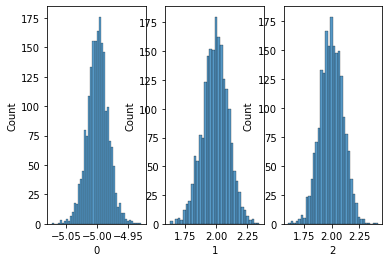

In [162]:
corr_pd = pd.DataFrame(wo_corr)
#corr_pd = corr_pd.loc[~(corr_pd==0).all(axis=1)]


fig, ax =plt.subplots(1,3)
sns.histplot(corr_pd[0], ax=ax[0])
sns.histplot(corr_pd[1], ax=ax[1])
sns.histplot(corr_pd[2], ax=ax[2])

fig.show()

In [163]:
corr_pd.mean()

0   -4.999492
1    1.995053
2    2.001204
3    3.998495
dtype: float64

C:\Users\glh287\AppData\Local\Temp/ipykernel_12528/1130882005.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


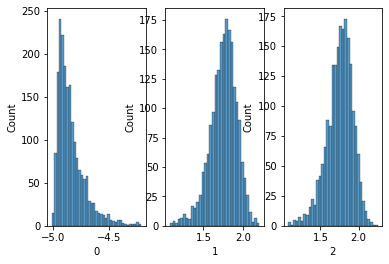

In [164]:
corr_pd = pd.DataFrame(with_corr)
#corr_pd = corr_pd.loc[~(corr_pd==0).all(axis=1)]

fig, ax =plt.subplots(1,3)
sns.histplot(corr_pd[0], ax=ax[0])
sns.histplot(corr_pd[1], ax=ax[1])
sns.histplot(corr_pd[2], ax=ax[2])

fig.show()

In [165]:
corr_pd.mean()

0   -4.837289
1    1.749702
2    1.753092
3    3.367022
dtype: float64

In [143]:
corr_pd = pd.DataFrame(with_corr_IV)
corr_pd = corr_pd.loc[~(corr_pd==0).all(axis=1)]

fig, ax =plt.subplots(1,3)
sns.histplot(corr_pd[0], ax=ax[0])
sns.histplot(corr_pd[1], ax=ax[1])
sns.histplot(corr_pd[2], ax=ax[2])

fig.show()

NameError: name 'with_corr_IV' is not defined

In [ ]:
corr_pd.mean()

0   -0.710496
1    0.405550
2    0.415301
dtype: float64

In [768]:
omega.shape

(4, 10)

In [779]:
cov = np.array([[1,0.8],[0.8,1]])

In [780]:
omega, sigma=data.cov_term(f,j,T, cov = cov)

np.corrcoef(omega.reshape(-1),sigma.reshape(-1))

array([[1.        , 0.85872036],
       [0.85872036, 1.        ]])

### Solved: I think the problem is negative marginal costs. 
Some combinations of parameters and data end up leading to corner solutions and hence the model become non-estimatable 

### Adding Instruments: 
BLP Instruments consist of: 
 - average attributes of own firm other products characteristics (if j = 1, then this instrument is invalid)
 - average attributes of other firm product characteristics.     


NameError: name 'X' is not defined

### Results
Unexpected result since OLS is able to recover the parameters of the model exactly. Right now the model is estimated Must be because pr

In [242]:
X.repeat(200, axis=0).shape

(1600, 2)

In [106]:
X.repeat(200, axis=0).shape


(800, 2)

In [26]:
mean = [0,0]
cov  = np.array([[1,0.1],[0.1,1]])
test=np.random.multivariate_normal(mean,cov,size = (f,j) )
test.shape

(5, 5, 2)

In [27]:
cov

array([[1. , 0.1],
       [0.1, 1. ]])

In [154]:
np.random.multivariate_normal([0,0],cov, size = (f*j)).shape

(50, 2)

In [24]:
x = np.array([1,1,1,0])
np.maximum(x, 0.5)

array([1. , 1. , 1. , 0.5])

In [ ]:



def sim_study_IV(Q,cov):
    parameters = np.zeros((Q,3))#+4*2))
    for q in tqdm(range(Q)): 
        try:
            f=2 # Firms
            j=3 # Products
            k=2 # Traits (of each product) 

            data = DE.endog_data()
            X, prod=data.simulate_product_traits(f,j,k, which_type = "Differentiated")
            X = X.reshape(j*f, -1)
            H = data.hadamard(f*j,prod)

            # True Parameters 
            alpha = -1                # Price sensitivity
            beta= np.array([1,1])        # Preference for traits 
            theta = np.append(alpha,beta)  
            #cov = np.array([[1,0.5],[0.5,1]])

            gamma = -np.array([1,1,1])
            T = 20
            P0 = np.zeros((f*j)) +1               #Initital price vector

            # Simulate data 
            S = np.array(0) 
            while S.min() == 0.0:
                P, S = data.sim_data_T(X, f, j, T, theta, gamma, cov, prod, H, disable = True)
            S.min()
            
            # constructing instruments: 
            # Not implemented

            #Estimation: 
            S0=(1-np.sum(S,axis=0))

            index=np.log(S/S0).reshape(-1,1)
            

            check = np.array(np.arange(j*f))
            Z = []
            for firm, js in prod.items():
                not_f_prods=[j for j in check if j not in js ]

                Z_i = X[not_f_prods,:].mean(axis=0)

                Z.append(Z_i)

            Z = np.array(Z) 

            ZZ = Z.repeat(T, axis=0)
            Piv1 = P.reshape(-1)


            results1step=OLS(Piv1,ZZ).fit()
            results1step.params

            EP = (ZZ @ results1step.params).reshape(-1,1)

            # Step 2 IV: 
            ZX = np.hstack((EP, X.repeat(T, axis=0)))
            #XX = XX[:,0:2]
            resultsIV=OLS(index,ZX).fit()
        
            parameters[q,:] = resultsIV.params
            
        except np.linalg.LinAlgError: 
            continue
    return parameters




    